## Ingest images
Images of each deer are roughly square, and stored in a local folder. The images are ingested via `glob` and files that do not contain year information is removed. Once ingested, resized, and stacked, the labels are extracted from each images based on their filename.

In [1]:
from glob import glob
from generic.analysis.basics import extract_labels
from generic.analysis.basics import ingest_resize_stack

# Find/ingest files in folder; force square & b/w
files = glob("..\\images\\squared\\*.png")
files = [s for s in files if "xpx" not in s]
print(len(files), "images found")

# Ingest images
images = ingest_resize_stack(files)
labels = extract_labels(files)

22 images found


## Split datasets
The image stack is then split into training and test data, with a split of 80/20 -- 80% of the data resides in the training set, while the remaining 20% defines the test data. The training and test data are then normalized, and the labels for each dataset are cast to categorical values instead of their age values.

The validation data is then extracted from the training dataset, again in an 80/20 split -- 80% of the previous training data remains within the training dataset, and 20% is redefined as the validation set. Each dataset (training, validation, and test) are reshaped based on their format of grayscale images.

In [12]:
import keras
import numpy as np
from sklearn.model_selection import train_test_split

# Convert labels to integers from 0 to 5 for proper one-hot encoding
# Create a mapping from your floating-point labels to integers
label_mapping = {label: i for i, label in enumerate(np.unique(labels))}
print("Label mapping:", label_mapping)

# Apply the mapping to convert labels to integers
integer_labels = np.array([label_mapping[l] for l in labels])
print("Converted labels:", integer_labels)

# Use a regular train_test_split without stratification
X_train, X_test, y_train, y_test = train_test_split(
    images, integer_labels, test_size=0.2, random_state=42
)

# Check the distribution after splitting
print("\nTraining set label distribution:")
unique_train_labels = np.unique(y_train)
for label in unique_train_labels:
    count = np.sum(y_train == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples ({count/len(y_train)*100:.2f}%)")

print("\nTest set label distribution:")
unique_test_labels = np.unique(y_test)
for label in unique_test_labels:
    count = np.sum(y_test == label)
    print(f"Label {label} ({list(label_mapping.keys())[list(label_mapping.values()).index(label)]}): {count} samples ({count/len(y_test)*100:.2f}%)")

# Normalize the images
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# One-hot encode labels with the correct number of classes
num_classes = len(label_mapping)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Create a validation set (without stratification)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Reshape data to add channel dimension
X_train = X_train.reshape(X_train.shape[0], 288, 288, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 288, 288, 1)
X_test = X_test.reshape(X_test.shape[0], 288, 288, 1)

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")
print(X_valid.shape[0], "validation samples")

Label mapping: {np.float64(1.1): 0, np.float64(1.5): 1, np.float64(2.5): 2, np.float64(3.5): 3, np.float64(4.5): 4, np.float64(5.5): 5}
Converted labels: [2 2 3 0 3 5 2 2 4 1 5 2 5 2 3 1 4 2 4 2 3 2]

Training set label distribution:
Label 0 (1.1): 1 samples (5.88%)
Label 1 (1.5): 1 samples (5.88%)
Label 2 (2.5): 6 samples (35.29%)
Label 3 (3.5): 4 samples (23.53%)
Label 4 (4.5): 2 samples (11.76%)
Label 5 (5.5): 3 samples (17.65%)

Test set label distribution:
Label 1 (1.5): 1 samples (20.00%)
Label 2 (2.5): 3 samples (60.00%)
Label 4 (4.5): 1 samples (20.00%)
13 train samples
5 test samples
4 validation samples


## Build network
With the data formatted and separated, we can now build the CNN.

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# First, let's check how many unique classes you actually have
num_classes = len(np.unique(labels))
print(f"Number of unique classes: {num_classes}")

# Make sure your final Dense layer matches this number
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(288, 288, 1)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
# Change this line to match your actual number of classes (6)
model.add(Dense(6, activation='softmax'))  # Change from 10 to 6

model.summary()

Number of unique classes: 6


G:\Dropbox\AI Projects\buck\buck-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 288, 288, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 144, 144, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 144, 144, 32)        │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 72, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 72, 72, 64)          │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 82944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 500)                 │      41,472,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │           3,006 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 41,486,002 (158.26 MB)

 Trainable params: 41,486,002 (158.26 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5.keras', verbose=1, save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=5, epochs=100, validation_data=(X_valid,y_valid), callbacks=[checkpointer], verbose=4, shuffle=True)

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.68576, saving model to model.weights.best.hdf5.keras
Epoch 2/100

Epoch 2: val_loss improved from 1.68576 to 1.67526, saving model to model.weights.best.hdf5.keras
Epoch 3/100

Epoch 3: val_loss did not improve from 1.67526
Epoch 4/100

Epoch 4: val_loss improved from 1.67526 to 1.62567, saving model to model.weights.best.hdf5.keras
Epoch 5/100

Epoch 5: val_loss improved from 1.62567 to 1.48593, saving model to model.weights.best.hdf5.keras
Epoch 6/100

Epoch 6: val_loss did not improve from 1.48593
Epoch 7/100

Epoch 7: val_loss did not improve from 1.48593
Epoch 8/100

Epoch 8: val_loss did not improve from 1.48593
Epoch 9/100

Epoch 9: val_loss did not improve from 1.48593
Epoch 10/100

Epoch 10: val_loss did not improve from 1.48593
Epoch 11/100

Epoch 11: val_loss did not improve from 1.48593
Epoch 12/100

Epoch 12: val_loss did not improve from 1.48593
Epoch 13/100

Epoch 13: val_loss improved from 1.48593 to 1.46203, saving 

Comprehensive Class Evaluation:
 Class Index  Original Label  In Test Set  In Predictions  Precision  Recall  F1 Score
           0             1.1        False           False        NaN     NaN       NaN
           1             1.5         True           False        NaN     NaN       NaN
           2             2.5         True            True        0.6     1.0      0.75
           3             3.5        False           False        NaN     NaN       NaN
           4             4.5         True           False        NaN     NaN       NaN
           5             5.5        False           False        NaN     NaN       NaN


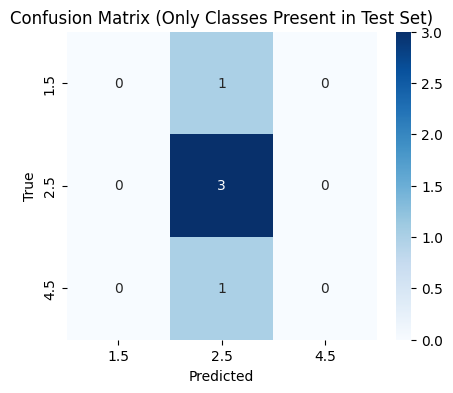


Overall Test Accuracy: 0.6000


In [17]:
# Create a reverse mapping to get original labels
reverse_mapping = {i: label for label, i in label_mapping.items()}

# Load the best weights
model.load_weights('model.weights.best.hdf5.keras')

# Make predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create a comprehensive evaluation table that includes all classes
all_classes = list(range(num_classes))
all_class_names = [reverse_mapping[i] for i in all_classes]

# Create a comprehensive DataFrame
results_df = pd.DataFrame({
    'Class Index': all_classes,
    'Original Label': all_class_names,
    'In Test Set': [i in y_true for i in all_classes],
    'In Predictions': [i in y_pred for i in all_classes]
})

# Add metrics where applicable
precision_values = []
recall_values = []
f1_values = []

for cls in all_classes:
    if cls in y_true and cls in y_pred:
        # We can calculate metrics for this class
        true_binary = (y_true == cls).astype(int)
        pred_binary = (y_pred == cls).astype(int)
        precision_values.append(precision_score(true_binary, pred_binary, zero_division=0))
        recall_values.append(recall_score(true_binary, pred_binary, zero_division=0))
        f1_values.append(f1_score(true_binary, pred_binary, zero_division=0))
    else:
        # Class not present in test set or predictions
        precision_values.append(float('nan'))
        recall_values.append(float('nan'))
        f1_values.append(float('nan'))

results_df['Precision'] = precision_values
results_df['Recall'] = recall_values
results_df['F1 Score'] = f1_values

print("Comprehensive Class Evaluation:")
print(results_df.to_string(index=False))

# Create a confusion matrix (will only show classes present in test set)
cm = confusion_matrix(y_true, y_pred)
present_classes = sorted(set(np.concatenate([y_true, y_pred])))
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[f"{reverse_mapping[i]}" for i in present_classes],
           yticklabels=[f"{reverse_mapping[i]}" for i in present_classes])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Only Classes Present in Test Set)')
plt.show()

# Show overall accuracy
accuracy = np.mean(y_pred == y_true)
print(f"\nOverall Test Accuracy: {accuracy:.4f}")